In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

In [2]:
# Parameters
l = 1.6  # L
dr = 0.15  # Distance between ears
theta = (18 / 180) * np.pi  # Half the speaker span
l1 = np.sqrt(l**2 + (dr / 2)**2 - (dr * l * np.sin(theta / 2)))  # L1
l2 = np.sqrt(l**2 + (dr / 2)**2 + (dr * l * np.sin(theta / 2)))  # L2
g = l1 / l2  # g
cs = 340.3  # Speed of sound
dl = abs(l2 - l1)  # Distance difference
tc = dl / cs  # Time delay
tau_s = 3
tau_c = 68e-6  # Time delay for a normal listening room
g = 0.985
fs = 44100
gamma_db = 7

$$
\gamma = 10^{\Gamma / 20}
$$ 

$$
\omega \tau_c
$$

In [3]:
def gamma_db2gain(db):
    return 10 ** (db / 20)

In [4]:
def compute_phi(g, gamma):
    return np.arccos((g * g * gamma * gamma + gamma * gamma - 1) / (2 * g * gamma * gamma))

In [5]:
def compute_band_edges(g, gamma, tau_c, fs):
    phi = compute_phi(g, gamma)
    bands = []
    
    f_nyquist = fs / 2
    omega_nyquist_tau = 2 * np.pi * f_nyquist * tau_c
    n_max = int(np.ceil(omega_nyquist_tau / (2 * np.pi))) 
    
    for n in range(n_max):
        omega_tau_0 =   (2*n+0)*np.pi - phi
        omega_tau_1 =   (2*n+0)*np.pi + phi
        omega_tau_2 =   (2*n+1)*np.pi - phi
        omega_tau_3 =   (2*n+1)*np.pi + phi
        omega_tau_4 = 2*(2*n+1)*np.pi - phi

        f0 = omega_tau_0 / (2 * np.pi * tau_c)
        f1 = omega_tau_1 / (2 * np.pi * tau_c)
        f2 = omega_tau_2 / (2 * np.pi * tau_c)
        f3 = omega_tau_3 / (2 * np.pi * tau_c)
        f4 = omega_tau_4 / (2 * np.pi * tau_c)

        if n == 0 and f0 < 0:
            f0 = 0
            omega_tau_0 = 0
        
        bands.append((omega_tau_0, omega_tau_1, f0, f1, 'b', 'Branch I'))
        bands.append((omega_tau_1, omega_tau_2, f1, f2, 'g', 'Branch P'))
        bands.append((omega_tau_2, omega_tau_3, f2, f3, 'r', 'Branch II'))
        bands.append((omega_tau_3, omega_tau_4, f3, f4, 'g', 'Branch P'))

    bands = [b for b in bands if b[2] < f_nyquist or b[3] <= f_nyquist]
    
    return bands

In [6]:
gamma = gamma_db2gain(gamma_db)
bands = compute_band_edges(g, gamma, tau_c, fs)

In [7]:
# Frequency and omega
f = np.arange(1, fs//2+1, 1)
w = 2 * np.pi * f

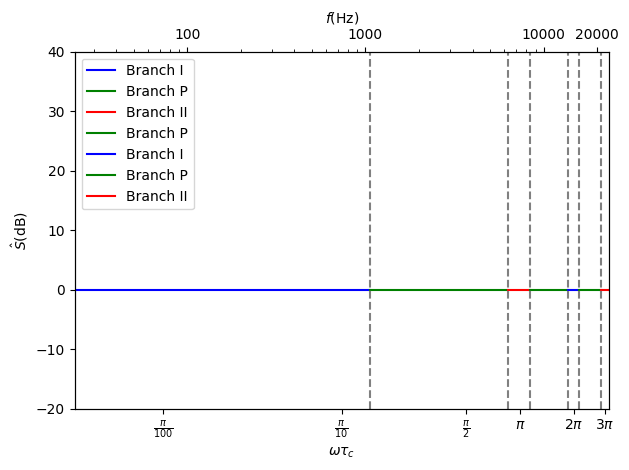

In [8]:
fig, ax1 = plt.subplots()

# Primary x-axis (w*tc)
for omega1, omega2, f1, f2, color, branch in bands:
    ax1.plot([omega1, omega2], [0, 0], color=color, label=branch)
    ax1.axvline(omega1, linestyle='--', color='gray')

ax1.set_xscale('log')
ax1.set_xlim(1 / 100, bands[-1][1])
ax1.set_xticks([np.pi / 100, np.pi / 10, np.pi / 2, np.pi, 2 * np.pi, 3 * np.pi])
ax1.set_xticklabels([r'$\frac{\pi}{100}$', r'$\frac{\pi}{10}$', r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$', r'$3\pi$'])

ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Calculate corresponding frequency ticks
major_freq_ticks = [100, 1000, 10000, 20000]
major_omega_tc_ticks = [2 * np.pi * f * tau_c for f in major_freq_ticks]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Align with primary x-axis
ax2.set_xscale('log')

ax2.set_xticks(major_omega_tc_ticks, minor=False)
ax2.set_xticklabels([str(f) for f in major_freq_ticks])

minor_freq_ticks = (
    list(range(30, 100, 10))    +   # 30, 40, ... , 90
    list(range(200, 1000, 100)) +   # 200, 300, ..., 900
    list(range(2000, 10000, 1000))  # 2000, 3000, ..., 9000
)
minor_omega_tc_ticks = [2 * np.pi * f * tau_c for f in minor_freq_ticks]
ax2.set_xticks(minor_omega_tc_ticks, minor=True)  # set minor ticks
ax2.tick_params(axis='x', which='minor', top=True, labeltop=False)

ax1.legend(loc='upper left')
ax1.set_xlabel(r'$\omega \tau_c$')
ax1.set_ylabel(r'$\hat{S}(\mathrm{dB})$')
ax2.set_xlabel(r'$f(\mathrm{Hz})$')

plt.ylim(-20, 40)
plt.tight_layout()
plt.show()